In [1]:
# Your choice of plotting front-end.

%matplotlib inline

import ROOT
tcanvas = ROOT.TCanvas("TCanvasName", "TCanvasTitle", 800, 600)

Welcome to JupyROOT 6.08/04


# Functional Playground

Let's back up and introduce the project properly.

No programming language is good at everything, and both C++ and Python are bad at parallel processing. Developing a good langauge for parallel processing is a frontier of computer science and has been for the past 20 years or so.

A few concepts are emerging as important for parallel processing:

   * **immutable, composable data**
   * **functionals instead of loops**
   * lazy evaluation
   * (actor-like isolation)
   * (asynchronous calls, callbacks, futures/promises)
   * (reactive APIs)

But only the first two or three are, in my opinion, relevant for _data analysis._

### Immutable, composable data

"Immutable" means that a quantity can't be changed after it has been created.

**Examples:**

   * In all programming languages, numbers are immutable. (Pascal let you change the definition of numbers like "4", but you couldn't change anything about their internal structure. And even so, it was widely regarded as a terrible idea.)
   * In Python but not C++, strings are immutable. Operating on a string in Python always creates a new string; the old one is either kept or garbage collected. In C++, you can change the characters of a string in-place, which makes string processing much more complicated.
   * In "purely functional" languages like Haskell, _all_ data are immutable. Every little change requires a new data structure. This isn't as bad as it sounds, but it takes some getting used to.

"Composable" means that you can use existing data to make new data. When you can't change data in-place, composing becomes the primary way of operating on data.

(A conceptual advantage of composing, rather than changing in-place, is that these operations can be identified as mathematical entities— mondoids, groups, and rings; commutative and/or associative— and that makes it easier to predict what they'll do using mathematical arguments.)

**Why is immutable data important?**

If you have multiple computers looking at the same data, they are necessarily looking at different _copies_ of the data. Any transfer of data through space is, strictly speaking, a copy. The original may or may not be deleted after or during the copy.

If a processor is allowed to change its copy of the data in-place, then the others either become out of date or have to be updated. Pausing processing to update a variable's state slows down processing, defeating the purpose of parallel processing. Thus, it's good to avoid it.

### Functionals instead of loops

A "functional" is a function that takes functions as arguments. (Other words for this are "functors" and "higher-order functions," but "functional" is used more in a physics context.)

You may remember functionals from classical or quantum mechanics: a Lagrangian is a functional that takes a field and its derivative as arguments, both of which are functions defined on all space-time. It's exactly the same idea in computer science.

Two particular functionals have become popular recently: `map` and `reduce`. The Hadoop framework, also known as "map-reduce," implements the `map` and `reduce` functionals over a cluster of networked computers, so that a data analyst only has to write their problem as functions to pass into `map` and `reduce` to submit their job.

Below, we'll play with `map`, `reduce`, and several other useful functionals.

### Lazy evaluation

Sometimes relevant for data analysis. A programming task can either be executed exactly where it is written or it may be delayed for later execution. "Lazy evaluation" is when the programming environment executes an expression at the latest possible time.

This concept was integrated into CMSSW's pipelines, so that producers are only invoked when and if their data are needed.

In Python, we see this distinction between lists, which are fully evaluated data in memory, and generators, which produce data on demand (lazily).

When a collection of data is evaluated lazily, it doesn't need to be finite. We'll be working with an infinite stream of CMS events.

# Functional programming in Python

The next three cells augment Python to make it more functional. We'll use it to tinker with data analysis in a functional setting as a way of motivating why the Histogrammar library is designed the way it is.

Go ahead and evaluate these three cells without examining them closely. I could have put these commands in an external Python module, but thought it would be better to keep everything in the open.

In [2]:
#### Please ignore the man behind the curtain...
#### This is just a hack to add new methods to Python's built-in types.

import ctypes

if hasattr(ctypes.pythonapi, "Py_InitModule4_64"):
    Py_ssize_t = ctypes.c_int64
else:
    ctypes.c_int

class PyObject(ctypes.Structure): pass
PyObject._fields_ = [("ob_refcnt", Py_ssize_t), ("ob_type", ctypes.POINTER(PyObject))]

class SlotsPointer(PyObject):
    _fields_ = [("dict", ctypes.POINTER(PyObject))]

def proxy_builtin(cls):
    name = cls.__name__
    slots = getattr(cls, "__dict__", name)

    pointer = SlotsPointer.from_address(id(slots))
    namespace = {}

    ctypes.pythonapi.PyDict_SetItem(
        ctypes.py_object(namespace),
        ctypes.py_object(name),
        pointer.dict
    )

    return namespace[name]

In [3]:
#### Define and attach functional methods to the Python "list" type.

def sizer(lst):
    """
    Return the length of the list.
    
    Example: [1, 2, 3, 4, 5].size == 5
    
    (For convenience, since everything else is attached at the end of a chain of methods.)
    """
    return len(lst)

def taker(lst):
    """
    Return the first n elements of the list.
    
    Example: [1, 2, 3, 4, 5].take(3) == [1, 2, 3]
    """
    if isinstance(lst, list):
        return lambda n: lst[:n]
    else:
        def gen(n):
            for i, x in enumerate(lst):
                yield x
                if i + 1 >= n: break
        return lambda n: list(gen(n))

def mapper(lst):
    """
    Apply a given function to each element of this list.
    
    The function must take one argument.
    
    Examples: [1, 2, 3, 4, 5].map(f) == [f(1), f(2), f(3), f(4), f(5)]
              [1, 2, 3, 4, 5].map(lambda x: x + 100) == [101, 102, 103, 104, 105]
    """
    if isinstance(lst, list):
        return lambda f: [f(x) for x in lst]
    else:
        return lambda f: (f(x) for x in lst)

def flattener(lst):
    """
    Turn a list-of-lists into a list of all elements. Only reduces one level of structure.
        
    Examples: [[1, 2], [3, 4, 5]].flatten == [1, 2, 3, 4, 5]
              [[1, 2], [3, [4, 5]]].flatten == [1, 2, 3, [4, 5]
    """
    if isinstance(lst, list):
        return sum(lst, [])
    else:
        def gen():
            for x in lst:
                for y in x:
                    yield y
        return gen()

def flatmapper(lst):
    """
    Same as [...].map(f).flatten, but these two operations are frequently done together.
    
    The function must take one argument.
    
    In general: [...].flatmap(f) == [...].map(f).flatten
    
    Example: [1, 2, 3, 4, 5].flatmap(lambda x: [x, x + 100]) == [1, 101, 2, 102, 3, 103, 4, 104, 5, 105]
    
    Flatmap is a very general operation. You can use it to expand a table, as above, or to map and filter
    at the same time. (In the theory of monads, "flatmap" is the fundamental "bind" operation.)
    
    Example: [1, 2, 3, 4, 5].flatmap(lambda x: [100 + x] if x > 2 else []) == [103, 104, 105]
    
    You might encounter this when you want to compute something for all particles in each event, but also
    handle the case when there are no particles after cuts. In that case, "flatmap" instead of "map" and
    return a singleton list [result] when you have a result and an empty list [] when you don't.
    """
    if isinstance(lst, list):
        return lambda f: sum((f(x) for x in lst), [])
    else:
        def gen(f):
            for x in lst:
                for y in f(x):
                    yield y
        return gen

def filterer(lst):
    """
    Apply a given function to each element of the list and return only those that return True.
    
    The function must take one argument and return True or False.
    
    Example: [1, 2, 3, 4, 5].filter(lambda x: x > 2) == [3, 4, 5]
    """
    if isinstance(lst, list):
        return lambda f: [x for x in lst if f(x)]
    else:
        def gen(f):
            for x in lst:
                if f(x):
                    yield x
        return gen
    
def reducer(lst):
    """
    Apply a given function to each element and a running tally to produce a single result.
    
    The function must take two arguments. The first may be an element from the list or a tally.
    The second will always be from the list.
    
    Examples: [1, 2, 3, 4, 5].reduce(f) == f(f(f(f(1, 2), 3), 4), 5)
              [1, 2, 3, 4, 5].reduce(lambda x, y: x + y) == 15
    """
    return lambda f: reduce(f, lst)

def aggregator(lst):
    """
    Same as reduce, except start the aggregation on a given zero element.
    
    The function must take two arguments. The first will always be a tally and the second from the list.
    
    Examples: [1, 2, 3, 4, 5].aggregate(f, 0) == f(f(f(f(f(0, 1), 2), 3), 4), 5)
              [1, 2, 3, 4, 5].aggregate(lambda x, y: x + y, 0) == 15
              ("a", "b", "c").aggregate(lambda x, y: x + y, "") == "abc"
    """
    return lambda f, zero: reduce(f, lst, zero)

def reducerright(lst):
    """
    Same as reduce, except start the nesting on the right and work left.
    
    The function must take two arguments. The second may be an element from the list or a tally.
    The first will always be from the list.
    
    Example: [1, 2, 3, 4, 5].reduceright(f) == f(1, f(2, f(3, f(4, 5))))
    """
    return lambda f: reduce(lambda a, b: f(b, a), reversed(lst))

def aggregatorright(lst):
    """
    Same as aggregate, except start the nesting on the right and work left.
    
    The function must take two arguments. The second will always be a tally and the first from the list.
    
    Example: [1, 2, 3, 4, 5].aggregateright(f, 0) == f(1, f(2, f(3, f(4, f(5, 0)))))
    """
    return lambda f, zero: reduce(lambda a, b: f(b, a), reversed(lst), zero)

def pairser(lst):
    """
    Apply a given function to pairs of elements without repetition (in either order) or duplicates.
    
    The function must take two arguments. Both will always be elements from the list.
    
    If you think of the input list as a vector X, this acts on the upper trianglular part of the
    outer product of X with X (not including diagonal).
    
    Alternatively, it's what you would get from these nested loops:
    
        for i in range(len(lst)):
            for j in range(i + 1, len(lst)):   # j starts at i + 1
                f(lst[i], lst[j])
    
    Example: [1, 2, 3, 4, 5].pairs(lambda x, y: [x, y]) == [[1, 2], [1, 3], [1, 4], [1, 5],
                                                                    [2, 3], [2, 4], [2, 5],
                                                                            [3, 4], [3, 5],
                                                                                    [4, 5]]
    
    Use this when you want to loop over pairs of distinct pairs of elements from a single list.
    
    Contrast with "table", which is like a nested loop over several lists, for all elements.
    """
    return lambda f: [f(x, y) for i, x in enumerate(lst) for y in lst[i + 1:]]

def tabler(lsts):
    """
    Apply a given function to all combinations of elements from all input lists.
    
    The function must take as many arguments as you have lists, and each will be an element from
    each list.
    
    If you think of the input lists as vectors X, Y, Z, etc., this acts on each element of the
    outer product of X with Y with Z, etc.
    
    Alternatively, it's what you would get from these nested loops:
    
        for x in lst_x:
            for y in lst_y:
                for z in lst_z:
                    f(x, y, z)
    
    Examples: [[100, 200], [1, 2, 3]].table(lambda x, y: x + y) == [101, 102, 103, 201, 202, 203]
    
              [[100, 200], [10, 20], [1, 2]].table(lambda x, y, z: x + y + z) == [
                  111, 112, 121, 122, 211, 212, 221, 222]

    To illustrate the difference between table and pairs, consider the following:

        [1, 2, 3].pairs(lambda x, y: [x, y]) == [[1, 2], [1, 3],
                                                         [2, 3]]
        
        [[1, 2, 3], [1, 2, 3]].table(lambda x, y: [x, y]) == [[1, 1], [1, 2], [1, 3],
                                                              [2, 1], [2, 2], [2, 3],
                                                              [3, 1], [3, 2], [3, 3]]
    """
    def buildargs(first, *rest):
        if len(rest) == 0:
            return [[x] for x in first]
        else:
            return [[x] + y for x in first for y in buildargs(*rest)]

    if len(lsts) < 2:
        raise TypeError("table requires at least two arguments")
    else:
        first = lsts[0]
        rest = lsts[1:]
        return lambda f: [f(*args) for args in buildargs(first, *rest)]

def zipper(lsts):
    """
    Apply a function to the ith element of each list, for all i.
    
    The function must take as many arguments as there are lists, and each will be an element from
    each list.
    
    This works just like the built-in Python zip, but applies the function to its results:
    
        for x, y, z in zip(lst_x, lst_y, lst_z):
            f(x, y, z)
    
    Example: [[1, 2, 3], ["a", "b", "c"], [101, 102, 103]].zip(lambda x, y, z: (x, y, z)) == [
                 (1, "a", 101), (2, "b", 102), (3, "c", 103)]
    """
    if len(lsts) < 2:
        raise TypeError("zip requires at least two arguments")
    else:
        return lambda f: [f(*args) for args in zip(*lsts)]

# attach the methods                                               force Python to notice
proxy_builtin(list)["size"] = property(sizer);                     hasattr([], "size")
proxy_builtin(list)["take"] = property(taker);                     hasattr([], "take")
proxy_builtin(list)["map"] = property(mapper);                     hasattr([], "map")
proxy_builtin(list)["flatten"] = property(flattener);              hasattr([], "flatten")
proxy_builtin(list)["flatmap"] = property(flatmapper);             hasattr([], "flatmap")
proxy_builtin(list)["filter"] = property(filterer);                hasattr([], "filter")
proxy_builtin(list)["reduce"] = property(reducer);                 hasattr([], "reduce")
proxy_builtin(list)["aggregate"] = property(aggregator);           hasattr([], "aggregate")
proxy_builtin(list)["reduceright"] = property(reducerright);       hasattr([], "reduceright")
proxy_builtin(list)["aggregateright"] = property(aggregatorright); hasattr([], "aggregateright")
proxy_builtin(list)["pairs"] = property(pairser);                  hasattr([], "pairs")
proxy_builtin(list)["table"] = property(tabler);                   hasattr([], "table")
proxy_builtin(list)["zip"] = property(zipper);                     hasattr([], "zip")

False

In [4]:
# Verify that they all work (and provide examples of their use).

assert [1, 2, 3, 4, 5].take(3) == [1, 2, 3]

assert [1, 2, 3, 4, 5].map(lambda x: 100 + x) == [101, 102, 103, 104, 105]

assert [[1, 2], [3, 4, 5]].flatten == [1, 2, 3, 4, 5]
assert [[1, 2], [3, [4, 5]]].flatten == [1, 2, 3, [4, 5]]

assert [1, 2, 3, 4, 5].map(lambda x: [x, x + 100]) == [[1, 101], [2, 102], [3, 103], [4, 104], [5, 105]]
assert [1, 2, 3, 4, 5].map(lambda x: [x, x + 100]).flatten == [1, 101, 2, 102, 3, 103, 4, 104, 5, 105]
assert [1, 2, 3, 4, 5].flatmap(lambda x: [x, x + 100]) == [1, 101, 2, 102, 3, 103, 4, 104, 5, 105]
assert [1, 2, 3, 4, 5].flatmap(lambda x: [100 + x] if x > 2 else []) == [103, 104, 105]

assert [1, 2, 3, 4, 5].filter(lambda x: x > 2) == [3, 4, 5]

assert [1, 2, 3, 4, 5].reduce(lambda x, y: x + y) == 15
assert [1, 2, 3, 4, 5].reduce(lambda x, y: [x, y]) == [[[[1, 2], 3], 4], 5]

assert ["a", "b", "c"].aggregate(lambda x, y: x + y, "") == "abc"
assert [1, 2, 3, 4, 5].aggregate(lambda x, y: [x, y], []) == [[[[[[], 1], 2], 3], 4], 5]

assert [1, 2, 3, 4, 5].reduceright(lambda x, y: [x, y]) == [1, [2, [3, [4, 5]]]]

assert [1, 2, 3, 4, 5].aggregateright(lambda x, y: [x, y], []) == [1, [2, [3, [4, [5, []]]]]]

assert [1, 2, 3, 4, 5].pairs(lambda x, y: [x, y]) == [[1, 2], [1, 3], [1, 4], [1, 5], [2, 3],
                                                      [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]

assert [[100, 200], [1, 2, 3]].table(lambda x, y: x + y) == [101, 102, 103, 201, 202, 203]
assert [[100, 200], [10, 20], [1, 2]].table(lambda x, y, z: x + y + z) == [111, 112, 121, 122, 211, 212, 221, 222]
assert [[1, 2, 3, 4, 5], ["a", "b"]].table(lambda x, y: [x, y]) == [
    [1, "a"], [1, "b"], [2, "a"], [2, "b"], [3, "a"], [3, "b"], [4, "a"], [4, "b"], [5, "a"], [5, "b"]]
assert [1, 2, 3].pairs(lambda x, y: [x, y]) == [[1, 2], [1, 3], [2, 3]]
assert [[1, 2, 3], [1, 2, 3]].table(lambda x, y: [x, y]) == [[1, 1], [1, 2], [1, 3],
                                                             [2, 1], [2, 2], [2, 3],
                                                             [3, 1], [3, 2], [3, 3]]

assert [[1, 2, 3], ["a", "b", "c"], [101, 102, 103]].zip(lambda x, y, z: [x, y, z]) == [
    [1, "a", 101], [2, "b", 102], [3, "c", 103]]

# Some functionals to play with

The `list` data type now has 13 new methods:

   * `[1, 2, 3, 4, 5].size` returns the size of the list, `5` (for convenience, not actually a functional because it takes no arguments and returns a number).   
   * `[1, 2, 3, 4, 5].take(3)` returns the first three elements, `[1, 2, 3]` (for convenience, not actually a functional because it takes a number and returns a list).
   * `[1, 2, 3, 4, 5].map(lambda x: x**2)` is the first functional: it applies the function `lambda x: x**2` to each element and makes a new list `[1, 4, 9, 16, 25]`.
   
You're probably familiar with the `def` syntax for making Python functions; if you haven't seen `lambda` before, it's a short-hand for making a function without the formality of naming it or using multiple lines. Try it out in the following cell.

In [5]:
def square(x):
    return x**2

print [1, 2, 3, 4, 5].map(square)

print [1, 2, 3, 4, 5].map(lambda x: x**2)

[1, 4, 9, 16, 25]
[1, 4, 9, 16, 25]


Here are some more.

   * `[1, 2, 3, 4, 5].filter(lambda x: x > 2)` applies a cut on the list, returning `[3, 4, 5]`. This is a very important functional, but doesn't require much explanation.
   * `[[1, 2], [3, 4, 5]].flatten` removes a layer of structure from a list, in this case returning `[1, 2, 3, 4, 5]`. That can be useful if you're turning a collection of events (containing many particles) into a "flattened" collection of particles (without regard for event boundaries). It's not really a functional (takes no arguments; returns a list), but it's useful for understanding what the next functional does...
   * `[1, 2, 3, 4, 5].flatmap(lambda x: [x, x + 100])` does `.map(...).flatten` in one step, producing `[1, 101, 2, 102, 3, 103, 4, 104, 5, 105]`. You'll find that this is surprisingly useful. For instance,
   
```
def dimuon(event):
    if event.muons.size < 2:
        return []
    else:
        mu1, mu2 = event.muons[:2]
        return [(mu1 + mu2).mass]

events.flatmap(dimuon)
```

computes dimuon masses from each event that has at least two muons and nothing from the rest. Returning either a singleton list with your answer or an empty list allows you to `filter` and `map` at the same time. (If you're interested in theory, `flatmap` is of foundational importance as the "bind" operation of a [monad](https://en.wikipedia.org/wiki/Monad_%28functional_programming%29)).

The next four functionals are tightly related: they're all ways of turning a list of data into a single datum. Histogramming is an example of that: you take a zillion events and turn it into a fixed-size data structure, maybe a 100-bin histogram. Histogrammar is really just a collection of fancy `aggregate` methods.

   * `[1, 2, 3, 4, 5].reduce(lambda x, y: x + y)` applies the given function to pairs of data iteratively, like this:

```
          f(f(f(f(1, 2), 3), 4), 5)
```

In this case, the operation `f` is to add pairs, and so the result is `15`.

   * `[1, 2, 3, 4, 5].reduceright(f)` does `f(1, f(2, f(3, f(4, 5))))`, which only matters if `f` is not associative (a bad idea; I hope we get a chance to see why) or the dataset is infinite.

The `aggregate` methods take an extra parameter, `zero`, which removes a subtlety from `reduce`: did you notice that the first time it was called on two elements of the list, `f(1, 2)` and every subsequent time it was called on a subtally and an element from the list, `f(f(1, 2), 3)`? That can make it awkward to write the function `f`, having to handle the two cases. The arguments to a function given to `aggregate` always take the same types.

For instance, consider this cheezy histogram-filler:

In [6]:
def fill(histogram, number):
    if 0 <= number < len(histogram):
        return histogram[:number] + [histogram[number] + 1] + histogram[number + 1:]
    else:
        return histogram

data = [3, 2, 4, 1, 2, 3, 1, 4, 1, 2, 3, 1, 2, 3, 0, 2, 3, 0, 1, 2, 4, 3, 2, 4, 1, 2, \
        3, 1, 0, 1, 2, 4, 3, 2, 4]

filled = data.aggregate(fill, zero=[0, 0, 0, 0, 0])

print filled

[3, 8, 10, 8, 6]


Here, the `zero` is an empty histogram; the function `fill` takes a partially filled histogram and a number from the dataset to fill it. If we had tried to do this with `reduce`, we'd have to handle the case in which `fill` is passed two numbers as arguments, rather than a histogram and a number.

The last three functionals emulate loops. In this functional environment, we won't be writing any loops ourselves.

   * `[1, 2, 3, 4, 5].pairs(lambda x, y: 100*x + y)` loops over pairs of elements from `[1, 2, 3, 4, 5]` without repetitions and applies the function to each pair: that is, `[f(1, 2), f(1, 3), f(1, 4), f(1, 5), f(2, 3), f(2, 4), f(2, 5), f(3, 4), f(3, 5), f(4, 5)]`. This is equivalent to the nested `for` loop

```
lst = [1, 2, 3, 4, 5]
for i in range(len(lst)):
    for j in range(i + 1, len(lst)):    # j is always larger than i
        f(lst[i], lst[j])               # in this case, f(lst[i], lst[j]) is 100*lst[i] + lst[j]
```

so the result of the calculation above is `[102, 103, 104, 105, 203, 204, 205, 304, 305, 405]`.

   * `[[1, 2, 3], [4, 5]].table(lambda x, y: 100*x + y)` loops over two lists, `[1, 2, 3]` and `[4, 5]`. Actually, you could use as many lists as you like, but the function must take as many arguments as lists, since each argument will be filled with an element from each: that is, `[f(1, 4), f(1, 5), f(2, 4), f(2, 5), f(3, 4), f(3, 5)]`. It is equivalent to the nested `for` loop

```
for x in [1, 2, 3]:
    for y in [4, 5]:
        f(x, y)                         # in this case, f(x, y) is 100*x + y
```

so the result of the calculation above is `[104, 105, 204, 205, 304, 305]`.

   * `[[1, 2, 3], [4, 5, 6]].zip(lambda x, y: 100*x + y)` also loops over a collection of lists, `[1, 2, 3]` and `[4, 5, 6]`. Now they have to have the same number of elements because they'll be iterated over like `[f(1, 4), f(2, 5), f(3, 6)]`, equivalent to the following `for` loop

```
x = [1, 2, 3]
y = [4, 5, 6]
for i in range(min(len(x), len(y))):
    f(x[i], y[i])                       # in this case, f(x[i], y[i]) is 100*x[i] + y[j]
```

so the result of the calculation above is `[104, 205, 306]`.


# Playtime

Now it's time to play! Let's get some CMS (public) data. And just to make sure that the fun never ends, let's get an infinite (unending) stream of them.

In [7]:
from histogrammar import *
from histogrammar.tutorial import cmsdata

def InfiniteEvents():
    while True:
        for event in cmsdata.EventIterator():
            yield event                         # "yield" is how you make a function into a generator in Python

events = InfiniteEvents()

This lazy stream of events is a `generator` type, rather than a `list`, so we have to attach our functional methods to this as well. I'm only going to attach the ones that won't cause your interpreter to go into an infinite loop.

You might think that `mapping` over an infinite collection would cause an infinite loop, but not when it's lazy. `generator.map(f)` doesn't compute anything, doesn't evaluate `f`— it just creates another generator that _would_ map `f` over the input on demand.

In [8]:
proxy_builtin(type(events))["take"] = property(taker);                     hasattr(events, "take")
proxy_builtin(type(events))["map"] = property(mapper);                     hasattr(events, "map")
proxy_builtin(type(events))["flatten"] = property(flattener);              hasattr(events, "flatten")
proxy_builtin(type(events))["flatmap"] = property(flatmapper);             hasattr(events, "flatmap")
proxy_builtin(type(events))["filter"] = property(filterer);                hasattr(events, "filter")

True

Now let's try some things. First, just take 3 from the infinite stream to look at them.

In [9]:
events.take(3)

[Event([], [Muon(4.85949611664, -30.2398738861, 137.776489258, 141.139785767, -1, 0.0)], [], [], MET(-8.67440891266, 21.8987998962), 7),
 Event([], [Muon(-23.3766021729, -21.3244667053, -21.4867858887, 38.2477645874, 1, 0.518906891346)], [], [], MET(26.8287220001, 29.009141922), 7),
 Event([], [], [], [], MET(-14.2947301865, 8.71030712128), 2)]

Okay. What kinds of methods do I have on these events? If we pull only one event off the stream, we get a list of one of them: `[event]`. So we have to use `[0]` to get the `event` itself.

In [10]:
dir(events.take(1)[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'electrons',
 'fromJson',
 'jets',
 'met',
 'muons',
 'numPrimaryVertices',
 'photons']

Okay. It has `electrons`, `jets`, `met`, `muons`, `numPrimaryVertices`, and `photons`. The rest is Python gunk. Let's try applying a function to pull out the muons.

In [11]:
events.map(lambda ev: ev.muons).take(10)

[[Muon(21.0245990753, 15.2924814224, 38.0825500488, 46.1105804443, 1, 0.0)],
 [Muon(7.49188518524, -39.8153266907, 19.95195961, 45.1606063843, -1, 4.2009472847)],
 [Muon(-4.77304172516, 36.630443573, -77.6554260254, 85.9938812256, -1, 1.50938034058)],
 [Muon(-11.5234136581, -21.5348072052, 3.72992348671, 24.7074985504, 1, 1.42479777336)],
 [],
 [],
 [Muon(-11.4520206451, 38.0730438232, -113.592842102, 120.349700928, -1, 1.3328255415)],
 [],
 [],
 []]

Most of these events have muons, some don't. (It was a [muon-triggered sample from 2010](http://opendata.cern.ch/record/203). CMS public data.) They probably have some jets, too.

In [12]:
events.map(lambda ev: ev.jets).take(20)

[[],
 [Jet(43.5943870544, -9.99415206909, 12.8462200165, 48.4479789734, -1.0),
  Jet(-13.8009996414, -29.7404193878, -12.8268785477, 35.4576072693, -1.0)],
 [],
 [],
 [Jet(-36.5394935608, -14.4588289261, -81.9849014282, 91.1192779541, -1.0)],
 [],
 [Jet(64.2288131714, 68.38697052, 371.880096436, 383.637115479, -1.0)],
 [],
 [],
 [],
 [Jet(39.9841346741, 44.048625946, 119.080718994, 133.31010437, -1.0),
  Jet(5.11166572571, -33.7828712463, -10.4385795593, 36.2952728271, -1.0),
  Jet(-33.1167907715, 3.72817444801, -130.43447876, 134.736083984, -1.0)],
 [Jet(10.7069778442, 32.4821891785, -53.2544746399, 63.611289978, -1.0)],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

Oh. Not many events have jets. Let's try filtering for events with at least one jet.

In [13]:
events.take(20).filter(lambda ev: ev.jets.size >= 1).size

2

Notice that if I put the `take(20)` _after_ the `filter`, rather than _before_ it, I get 20 results. Explain to yourself why that is.

In [14]:
events.filter(lambda ev: ev.jets.size >= 1).take(20).size

20

Now let me show you the glory of `flatmap`. By `flatmapping` over jets, rather than `mapping`, we get a stream of jets, rather than a stream of events. We've lost information: which jets belong to which events. However, this is exactly what you want to do if you're doing a jet study, rather than a physics analysis. Similarly, alignment and calibration care about tracks and showers instead of events.

In [15]:
events.flatmap(lambda ev: ev.jets).take(20)

[Jet(-32.8055610657, -1.9215439558, -18.3760948181, 38.1614227295, -1.0),
 Jet(-35.7217674255, 40.3134269714, 202.36517334, 209.550003052, -1.0),
 Jet(-26.537481308, -43.619392395, 37.9836845398, 64.6566925049, -1.0),
 Jet(7.81694459915, 45.3634414673, -62.6137695312, 78.7132873535, -1.0),
 Jet(36.1999282837, 88.4749832153, 42.1356697083, 105.94695282, -1.0),
 Jet(-26.4425582886, 19.4879741669, 186.818405151, 189.8309021, -1.0),
 Jet(26.9815826416, 31.5266056061, -69.2858352661, 81.3827896118, -1.0),
 Jet(25.1152648926, -23.2613735199, 39.2988433838, 52.379611969, -1.0),
 Jet(4.15257835388, -41.388469696, -157.774581909, 163.271347046, -1.0),
 Jet(52.2988166809, 11.0969152451, -29.3882198334, 61.367023468, -1.0),
 Jet(42.3602790833, -12.7046165466, 51.7379150391, 68.2978744507, -1.0),
 Jet(-43.6951522827, 26.9825553894, -2.14704680443, 51.6978607178, -1.0),
 Jet(3.03745126724, -41.6156463623, 33.8255195618, 54.2581520081, -1.0),
 Jet(-31.2498207092, 16.7006816864, 77.4445648193, 85.282

But now let's do some physics. Let's see what methods are available to us on the particle objects.

In [16]:
dir(events.flatmap(lambda ev: ev.muons).take(1)[0])

['E',
 '__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'eta',
 'fromJson',
 'iso',
 'mass',
 'p',
 'phi',
 'pt',
 'px',
 'py',
 'pz',
 'q']

There's `E` (energy), `eta` (pseudorapidity), `iso` (isolation), `mass` (mass), `p` (momentum), `phi` (azimuthal angle), `pt` (transverse momentum), `px`, `py`, `pz` (Cartesian components), and `q` (charge), and then some Python junk.

But don't ignore the `__add__` method, which knows about 4-momentum kinematics.

In [17]:
mu1, mu2 = events.flatmap(lambda ev: ev.muons).take(2)

print mu1 + mu2
print (mu1 + mu2).mass

LorentzVector(20.4720554352, 49.0557975769, 97.6934432983, 133.248703003)
73.3868629853


Great! Then we can look for the Z boson. This function will require two lines, so we define it longhand.

In [18]:
def dimuon(event):
    mu1, mu2 = event.muons[:2]
    return (mu1 + mu2).mass

events.filter(lambda ev: ev.muons.size >= 2).map(dimuon).take(20)

[90.59405647767977,
 99.54980031423942,
 90.16057143550684,
 93.47173495498177,
 3.953625857643265,
 3.934012322364818,
 45.08225898569615,
 79.15001349842068,
 84.05077693770595,
 93.45965877179938,
 91.31698863152324,
 91.19897690101983,
 93.86448335113091,
 86.60525038219909,
 91.10639148544332,
 89.54668504763143,
 110.40644207615776,
 90.72280640958388,
 91.03991798978788,
 35.77450376728666]

Looks like a lot of dimuons have a mass around 90 GeV. What's the average?

In [19]:
events.filter(lambda ev: ev.muons.size >= 2).map(dimuon).take(100).reduce(lambda x, y: x + y) / 100.0

86.69101301194657

A little low for the Z mass, but that's because Drell-Yan and heavy flavor muons are pulling the average down. To analyze the shape, we'd need a plot. Time to bring in Histogrammar.

In keeping with these functional chains, let's make all the Histogrammar aggregators into methods on `list`. Remember that they're all just fancy kinds of `reduce`/`aggregate` methods.

In [20]:
def histogrammarMethod(cls):
    def generatorProperty(lst):
        def hargs(*args, **kwds):
            h = cls(*args, **kwds)
            for x in lst:
                h.fill(x)
            return h
        return hargs
    return generatorProperty

# rename UntypedLabel as "Bundle" because that's what it will be in Histogrammar specification 2.0
Bundle = UntypedLabel

proxy_builtin(list)["Average"] = property(histogrammarMethod(Average));                hasattr(list, "Average")
proxy_builtin(list)["Bin"] = property(histogrammarMethod(Bin));                        hasattr(list, "Bin")
proxy_builtin(list)["Categorize"] = property(histogrammarMethod(Categorize));          hasattr(list, "Categorize")
proxy_builtin(list)["CentrallyBin"] = property(histogrammarMethod(CentrallyBin));      hasattr(list, "CentrallyBin")
proxy_builtin(list)["Label"] = property(histogrammarMethod(Label));                    hasattr(list, "Label")
proxy_builtin(list)["Bundle"] = property(histogrammarMethod(Bundle));                  hasattr(list, "Bundle")
proxy_builtin(list)["Index"] = property(histogrammarMethod(Index));                    hasattr(list, "Index")
proxy_builtin(list)["Branch"] = property(histogrammarMethod(Branch));                  hasattr(list, "Branch")
proxy_builtin(list)["Count"] = property(histogrammarMethod(Count));                    hasattr(list, "Count")
proxy_builtin(list)["Deviate"] = property(histogrammarMethod(Deviate));                hasattr(list, "Deviate")
proxy_builtin(list)["Fraction"] = property(histogrammarMethod(Fraction));              hasattr(list, "Fraction")
proxy_builtin(list)["IrregularlyBin"] = property(histogrammarMethod(IrregularlyBin));  hasattr(list, "IrregularlyBin")
proxy_builtin(list)["Minimize"] = property(histogrammarMethod(Minimize));              hasattr(list, "Minimize")
proxy_builtin(list)["Maximize"] = property(histogrammarMethod(Maximize));              hasattr(list, "Maximize")
proxy_builtin(list)["Select"] = property(histogrammarMethod(Select));                  hasattr(list, "Select")
proxy_builtin(list)["SparselyBin"] = property(histogrammarMethod(SparselyBin));        hasattr(list, "SparselyBin")
proxy_builtin(list)["Stack"] = property(histogrammarMethod(Stack));                    hasattr(list, "Stack")
proxy_builtin(list)["Sum"] = property(histogrammarMethod(Sum));                        hasattr(list, "Sum")

True

When we put a `Bin` aggregator at the end of this chain of functionals, we give it the same `dimuon` function we gave `map`. It should be getting more clear why Histogrammar uses fill rules, rather than relying on being called the appropriate way in a `for` loop.

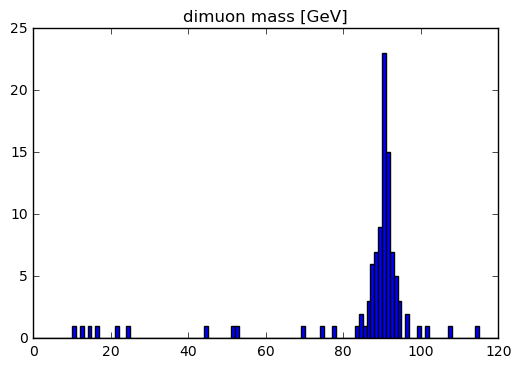

In [21]:
events.filter(lambda ev: ev.muons.size >= 2).take(100).Bin(120, 0, 120, dimuon) \
      .plot.matplotlib("dimuon mass [GeV]")

That's more like it. We win the 1984 Nobel prize!

# Histogrammar for functional programming

All of the Histogrammar aggregators (except `Count`) take a function as an argument, to pick the thing to aggregate out of the event.

For a complete reference on what each aggregator does, see [the specification](http://histogrammar.org/docs/specification/1.0/). Below, I'll give some illustrative examples.

In [22]:
muonpairs = events.filter(lambda ev: ev.muons.size >= 2).map(lambda ev: ev.muons[:2]).take(100)

def tomass(muons):
    mu1, mu2 = muons
    return (mu1 + mu2).mass

print muonpairs.Count()
print muonpairs.Sum(tomass)
print muonpairs.Average(tomass)
print muonpairs.Deviate(tomass)
print muonpairs.Minimize(tomass)
print muonpairs.Maximize(tomass)

<Count 100.0>
<Sum sum=8453.62036182>
<Average mean=84.5362036182>
<Deviate mean=84.5362036182 variance=361.330576409>
<Minimize min=3.58367284228>
<Maximize max=108.901247957>


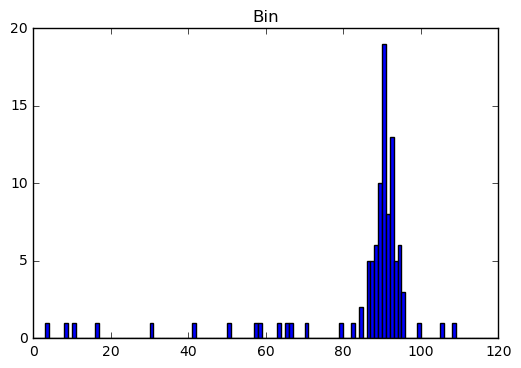

In [23]:
# standard binning
muonpairs.Bin(120, 0, 120, tomass).plot.matplotlib()

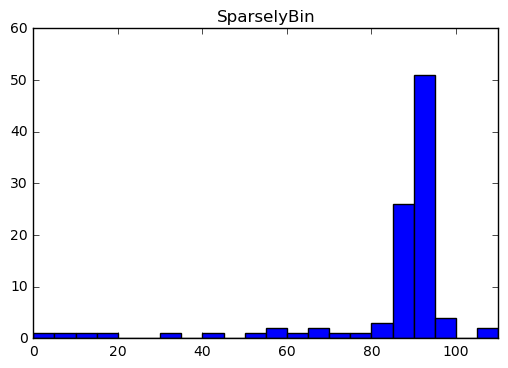

In [24]:
# only specify a bin width (5 GeV): bins will only be created if nonzero
muonpairs.SparselyBin(5, tomass).plot.matplotlib()

For the next few features, I want to look at muon isolation. We'll start without plotting because I have no idea how this isolation variable is scaled.

In [25]:
thousandmuons = events.flatmap(lambda ev: ev.muons).take(1000)

thousandmuons.map(lambda muon: muon.iso).take(10)

[3.1873316764831543,
 0.0,
 2.2858545780181885,
 0.8116026520729065,
 0.5737981796264648,
 1.2585299015045166,
 2.690613031387329,
 1.2594029903411865,
 0.8264614343643188,
 1.85421884059906]

Okay, zero to five ought to do it.

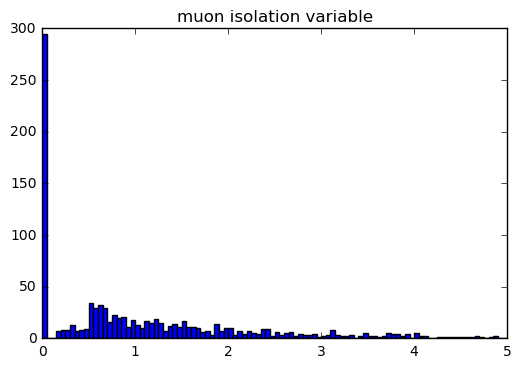

In [26]:
thousandmuons.Bin(100, 0, 5, lambda muon: muon.iso).plot.matplotlib("muon isolation variable")

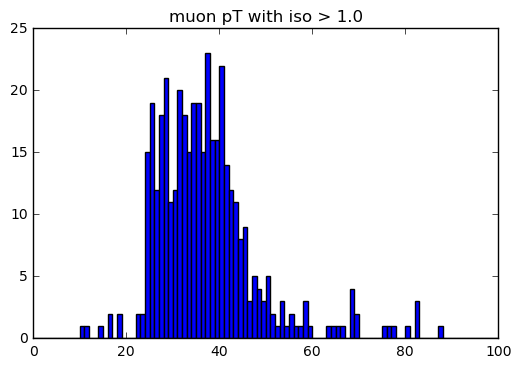

In [27]:
# Select applies a cut at the Histogrammar level; it differs from "filter" only in that other
# Histogrammar primitives are nested within it, rather than chained after it. That will be important in a moment.

thousandmuons.Select(lambda muon: muon.iso > 1.0, Bin(100, 0, 100, lambda muon: muon.pt)) \
             .plot.matplotlib("muon pT with iso > 1.0")

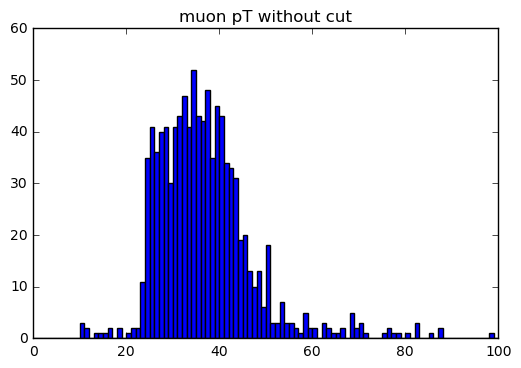

In [28]:
thousandmuons.Bin(100, 0, 100, lambda muon: muon.pt).plot.matplotlib("muon pT without cut")

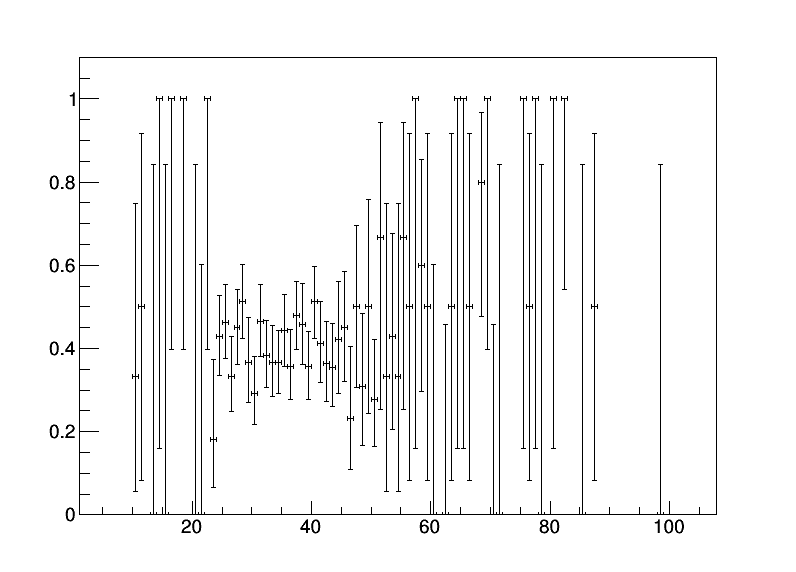

In [29]:
# Fraction is a relative of Select that makes two histograms and divides them
# I'm using ROOT to plot this one, rather than Matplotlib, because of a bug in this version handling
# bins with zero entries.

tefficiency = thousandmuons.Fraction(lambda muon: muon.iso > 1.0, Bin(100, 0, 100, lambda muon: muon.pt)).plot.root("TEfficiency", "Cut efficiency versus pT")
tefficiency.Draw()
tcanvas.Draw()

# Nesting Histogrammar aggregators

In the last two examples, we put a `Bin` inside a `Select` or a `Fraction`. This is what makes Histogrammar extensible. Some aggregators take other aggregators as arguments, and you can use that to make infinitely many histogram types. Let's start with some simple ones.

Did you notice that there aren't any "profile" or "two-dimensional" aggregators? That's because we can make them.

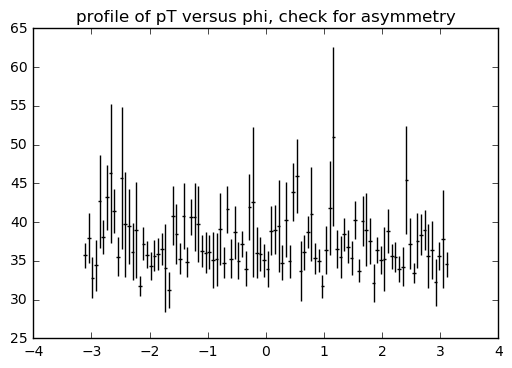

In [30]:
import math

thousandmuons.Bin(100, -math.pi, math.pi, lambda muon: muon.phi, Deviate(lambda muon: muon.pt)).plot.matplotlib("profile of pT versus phi, check for asymmetry")

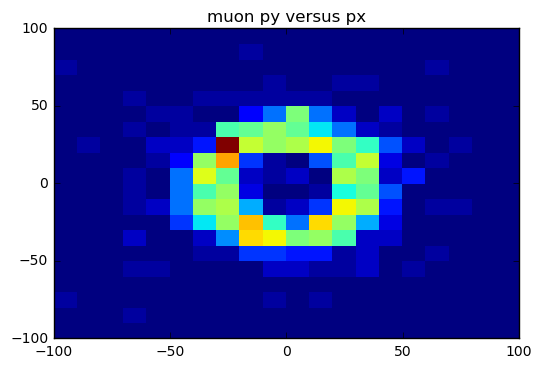

In [31]:
# make two-dimensional histograms by nesting a Bin within a Bin
thousandmuons.Bin(20, -100, 100, lambda muon: muon.px, Bin(20, -100, 100, lambda muon: muon.py)).plot.matplotlib("muon py versus px")

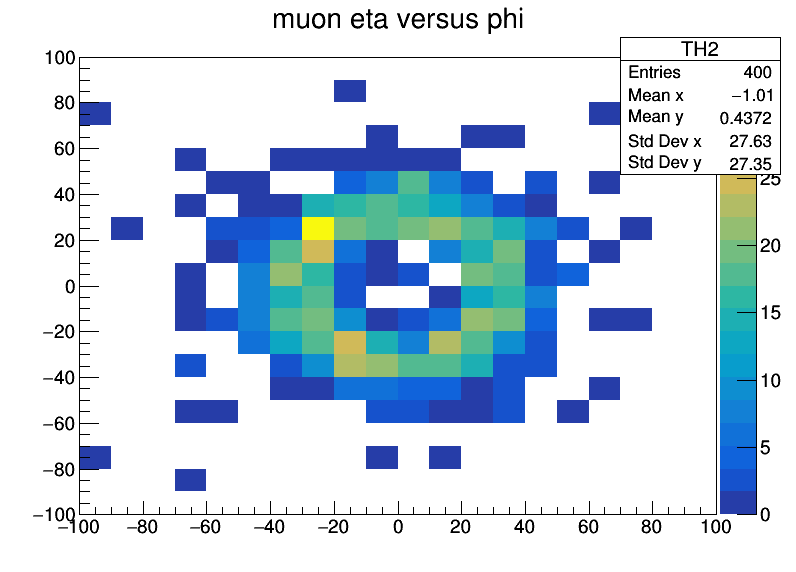

In [32]:
# you can do this in ROOT, too
root2d = thousandmuons.Bin(20, -100, 100, lambda muon: muon.px, Bin(20, -100, 100, lambda muon: muon.py)).plot.root("TH2", "muon eta versus phi")
root2d.Draw("colz")
tcanvas.Draw()

# Bundles of histograms

The best nesting function of all is `Bundle` (called `UntypedLabel` in Histogrammar 1.0; I'm going to use the future name everywhere).

It works like ROOT's directories of histograms: it's how you label them with names and organize them. It also lets you fill multiple histograms in one pass over the data.

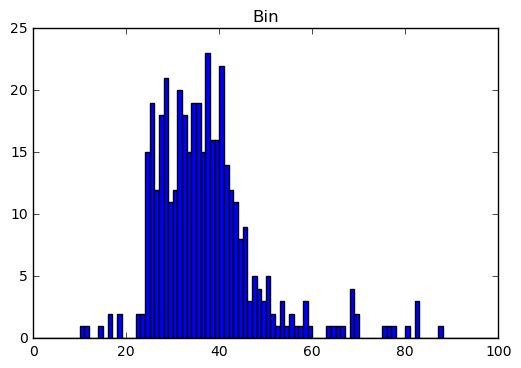

In [33]:
# fill all three histograms
allhists = thousandmuons.Bundle(
    withcut    = Select(lambda muon: muon.iso > 1.0, Bin(100, 0, 100, lambda muon: muon.pt)),
    withoutcut =                                     Bin(100, 0, 100, lambda muon: muon.pt),
    iso        =                                     Bin(100, 0, 5, lambda muon: muon.iso))

allhists.get("withcut").plot.matplotlib()

Now the value of `Select`, a nestable `filter`, should be clear. You can apply it to some histograms in a `Bundle` and not others. You can build up a whole packet-of-plots as one big Histogrammar tree.

# Unplottable aggregations

You can combine these aggregators in infinitely many ways, but there aren't infinitely many plotting routines in every plotting package, so many of these combinations don't have a visualization. You'll get some error message like "no method found."

However, don't let that stop you from making them. Filled aggregators are useful for many things other than immediately plotting them, and I think you'll find that many of the mechanations and work-arounds you do with `TH3` and relatives can be expressed more naturally in aggregators.

Here's an example of gathering useful information about a distribution, even though we can't plot it.

In [34]:
mu_iso_ranges_by_pt_and_q = thousandmuons. \
    SparselyBin(1, lambda muon: muon.q,                                              # in bins of charge
                Bin(20, 0, 100, lambda muon: muon.pt,                                # in bins of pT
                    Bundle(nonzero = Fraction(lambda muon: muon.iso > 0, Count()),   # how many isos are nonzero?
                           average = Average(lambda muon: muon.iso),                 # what's the average?
                           maximum = Maximize(lambda muon: muon.iso))))              # what's the maximum?

Before attempting to navigate this structure, let's just print it all out.

In [35]:
mu_iso_ranges_by_pt_and_q.toJson()

{'data': {'binWidth': 1,
  'bins': {'-1': {'entries': 430.0,
    'high': 100.0,
    'low': 0.0,
    'nanflow': 0.0,
    'nanflow:type': 'Count',
    'overflow': 5.0,
    'overflow:type': 'Count',
    'underflow': 0.0,
    'underflow:type': 'Count',
    'values': [{'data': {'average': {'data': {'entries': 0.0, 'mean': 'nan'},
        'type': 'Average'},
       'maximum': {'data': {'entries': 0.0, 'max': 'nan'}, 'type': 'Maximize'},
       'nonzero': {'data': {'denominator': 0.0,
         'entries': 0.0,
         'numerator': 0.0,
         'sub:type': 'Count'},
        'type': 'Fraction'}},
      'entries': 0.0},
     {'data': {'average': {'data': {'entries': 0.0, 'mean': 'nan'},
        'type': 'Average'},
       'maximum': {'data': {'entries': 0.0, 'max': 'nan'}, 'type': 'Maximize'},
       'nonzero': {'data': {'denominator': 0.0,
         'entries': 0.0,
         'numerator': 0.0,
         'sub:type': 'Count'},
        'type': 'Fraction'}},
      'entries': 0.0},
     {'data': {'avera

There's a lot of information in there. The JSON representation is intended for transmitting the data over a network, but it's human readable and can help you get started finding the data that you want. You might even iterate over the JSON structure, rather than using the methods built into the Python objects that I'll show below. Up to you.

In [36]:
# top level is a SparselyBin
mu_iso_ranges_by_pt_and_q

<SparselyBin binWidth=1 bins=Bin nanflow=Count>

In [37]:
# it found two bins of charge, -1 and 1 (unsurprisingly, but I did it with a SparselyBin, rather than Bin,
# because I didn't know if it would be 0 and 1 or something)
mu_iso_ranges_by_pt_and_q.bins

{-1: <Bin num=20 low=0.0 high=100.0 values=UntypedLabel underflow=Count overflow=Count nanflow=Count>,
 1: <Bin num=20 low=0.0 high=100.0 values=UntypedLabel underflow=Count overflow=Count nanflow=Count>}

In [38]:
# the next level is a Bin (see above), and this has 20 values; each is an UntypedLabel (Bundle)
mu_iso_ranges_by_pt_and_q.bins[-1].values

[<UntypedLabel size=3>,
 <UntypedLabel size=3>,
 <UntypedLabel size=3>,
 <UntypedLabel size=3>,
 <UntypedLabel size=3>,
 <UntypedLabel size=3>,
 <UntypedLabel size=3>,
 <UntypedLabel size=3>,
 <UntypedLabel size=3>,
 <UntypedLabel size=3>,
 <UntypedLabel size=3>,
 <UntypedLabel size=3>,
 <UntypedLabel size=3>,
 <UntypedLabel size=3>,
 <UntypedLabel size=3>,
 <UntypedLabel size=3>,
 <UntypedLabel size=3>,
 <UntypedLabel size=3>,
 <UntypedLabel size=3>,
 <UntypedLabel size=3>]

In [39]:
# if you remember, we put three things into each of these Bundles
mu_iso_ranges_by_pt_and_q.bins[-1].values[5].pairs

{'average': <Average mean=1.21924765964>,
 'maximum': <Maximize max=3.91194200516>,
 'nonzero': <Fraction values=Count>}

In [40]:
# the Average and Maximize show you the values in their printable representation; for Fraction we have to dig
print mu_iso_ranges_by_pt_and_q.bins[-1].values[5].get("nonzero").numerator
print mu_iso_ranges_by_pt_and_q.bins[-1].values[5].get("nonzero").denominator

<Count 57.0>
<Count 75.0>


In [41]:
# okay, so now iterating over pt and q...
for q, pts in mu_iso_ranges_by_pt_and_q.bins.items():
    print "Charge {0}:".format(q)
    for index, bundle in enumerate(pts.values):
        print "    pT {0}-{1}:".format(*pts.range(index)),
        numer = bundle.get("nonzero").numerator.entries
        denom = bundle.get("nonzero").denominator.entries
        print "nonzero {0}/{1} = {2} average {3} maximum {4}".format(
            numer, denom, numer / denom if denom != 0 else "nan",
            bundle.get("average").mean, bundle.get("maximum").max)

Charge 1:
    pT 0.0-5.0: nonzero 0.0/0.0 = nan average nan maximum nan
    pT 5.0-10.0: nonzero 0.0/0.0 = nan average nan maximum nan
    pT 10.0-15.0: nonzero 2.0/4.0 = 0.5 average 0.479390077293 maximum 1.58960151672
    pT 15.0-20.0: nonzero 2.0/2.0 = 1.0 average 1.08348196745 maximum 1.57132637501
    pT 20.0-25.0: nonzero 21.0/31.0 = 0.677419354839 average 0.858180856512 maximum 3.1094121933
    pT 25.0-30.0: nonzero 81.0/113.0 = 0.716814159292 average 1.01439523868 maximum 4.04811620712
    pT 30.0-35.0: nonzero 103.0/141.0 = 0.730496453901 average 1.08474007798 maximum 4.58071756363
    pT 35.0-40.0: nonzero 80.0/117.0 = 0.683760683761 average 0.999126521823 maximum 4.87084007263
    pT 40.0-45.0: nonzero 65.0/85.0 = 0.764705882353 average 1.17499895482 maximum 5.71728992462
    pT 45.0-50.0: nonzero 29.0/35.0 = 0.828571428571 average 1.11871724597 maximum 3.46588015556
    pT 50.0-55.0: nonzero 10.0/16.0 = 0.625 average 1.02076280676 maximum 3.70744895935
    pT 55.0-60.0: non

You can use this information however you like. Notice that building the aggregator and applying it to a data stream was easy. If anything was hard, it was figuring out how to dig through it and find what we've collected.

That's where you use "`dir`" on the Python command line. It's just a matter of tinkering.

# Composability

Now here comes the best part: all of these aggregators share a mathematical property— they are perfectly composable. For instance, you can get averages from two different data runs and combine them to get the average of the whole dataset (not an average of averages).

For instance,

In [52]:
# these datasets don't overlap: the 20 muons in data2 come AFTER the 10 muons in data1
data1 = events.flatmap(lambda ev: ev.muons).take(10)
data2 = events.flatmap(lambda ev: ev.muons).take(20)

average1 = data1.Average(lambda muon: muon.iso)
average2 = data2.Average(lambda muon: muon.iso)

print average1, average2

<Average mean=1.05491231084> <Average mean=0.880300368369>


In [53]:
print "The combined average is", (average1 + average2).mean

print "Which is not the same as the average of averages", (average1.mean + average2.mean) / 2.0

print "It is, however, the same as the weighted average of averages", \
    (average1.mean * average1.entries + average2.mean * average2.entries) / (average1.entries + average2.entries)

The combined average is 0.938504349192
Which is not the same as the average of averages 0.967606339604
It is, however, the same as the weighted average of averages 0.938504349192


In [54]:
print "You can also see this by running all the data through one aggregator:"
print (data1 + data2).Average(lambda muon: muon.iso)

You can also see this by running all the data through one aggregator:
<Average mean=0.938504349192>


(Check all the digits on the above examples; it can be a small difference.)

You can do this on more complex aggregators, such as histograms, so that the "+" operator becomes Histogrammar's equivalent of ROOT's `hadd`. Just to make a point, I'm going to do the ridiculously complex aggregator again over two datasets and then combine them with "+".

In [55]:
one_thousandmuons = events.flatmap(lambda ev: ev.muons).take(1000)
another_thousandmuons = events.flatmap(lambda ev: ev.muons).take(1000)

def complex_aggregator(data):
    return data. \
    SparselyBin(1, lambda muon: muon.q,                                              # in bins of charge
                Bin(20, 0, 100, lambda muon: muon.pt,                                # in bins of pT
                    Bundle(nonzero = Fraction(lambda muon: muon.iso > 0, Count()),   # how many isos are nonzero?
                           average = Average(lambda muon: muon.iso),                 # what's the average?
                           maximum = Maximize(lambda muon: muon.iso))))              # what's the maximum?

one_aggregation = complex_aggregator(one_thousandmuons)
another_aggregation = complex_aggregator(another_thousandmuons)
combined_aggregation = complex_aggregator(one_thousandmuons + another_thousandmuons)

import histogrammar.util
histogrammar.util.relativeTolerance = 1e-12   # allow for some round-off error
histogrammar.util.absoluteTolerance = 1e-12

one_aggregation + another_aggregation == combined_aggregation

True

This innocent-looking "+" sign recursively navigated that complex structure and combined all the partial aggregations in a statistically correct way for non-overlapping datasets.

The suite of aggregators have been specially designed so that the combine operation is always exact (modulo floating point round-off error). Your aggregation can therefore be split up into arbitrarily many pieces, aggregated in parallel on remote machines, and recombined when pulling them back. 

![parallelization](parallelization.png)

This is the mode of operation Histogrammar was designed for, and you'll be using it that way more and more as tools like Apache Spark become more common.